In the previous notebook, we set up a framework for doing gradient-based minimization of differentiable functions (via the `GradientDescent` typeclass) and implemented simple gradient descent for univariate functions. Next, let's try to extend this framework to a faster method such as nonlinear Conjugate Gradient, and see what modifications we'll need to make in order to accomodate it.
$\newcommand\vector[1]{\langle #1 \rangle}\newcommand\p[2]{\frac{\partial #1}{\partial #2}}\newcommand\R{\mathbb{R}}$

Conjugate Gradient
===
Before diving in to Haskell, let's go over exactly what the conjugate gradient method is and why it works. The "normal" conjugate gradient method is a method for solving systems of linear equations. However, this extends to a method for minimizing quadratic functions, which we can subsequently generalize to minimizing arbitrary functions $f\!:\!\R^n \to \R$. We will start by going over the conjugate gradient method of minimizing quadratic functions, and later generalize.

Suppose we have some quadratic function
$$f(x) = \frac{1}{2}x^T A x + b^T x + c$$
for $x \in \R^n$ with $A \in \R^{n \times n}$ and  $b, c \in \R^n$.

We can write any quadratic function in this form, as this generates all the coefficients $x_ix_j$ as well as linear and constant terms. In addition, we can assume that $A = A^T$ ($A$ is symmetric). (If it were not, we could just rewrite this with a symmetric $A$, since we could take the term for $x_i x_j$ and the term for $x_j x_i$, sum them, and then have $A_{ij} = A_{ji}$ both be half of this sum.)

Taking the gradient of $f$, we obtain
$$\nabla f(x) = A x + b,$$
which you can verify by writing out the terms in summation notation.

If we evaluate $-\nabla f$ at any given location, it will give us a vector pointing towards the direction of steepest descent. This gives us a natural way to start our algorithm - pick some initial guess $x_0$, compute the gradient $-\nabla f(x_0)$, and move in that direction by some step size $\alpha$. Unlike normal gradient descent, however, we do not have a fixed step size $\alpha$ - instead, we perform a line search in order to find the *best* $\alpha$. This $\alpha$ is the value of $\alpha$ which brings us to the minimum of $f$ if we are constrainted to move in the direction given by $d_0 = -\nabla f(x_0)$.

Note that computing $\alpha$ is equivalent to minimizing the function
$$\begin{align*}
g(\alpha) &= f(x_0 + \alpha d_0) \\
&= \frac{1}{2}(x_0 + \alpha d_0)^T A (x_0 + \alpha d_0) + b^T (x_0 + \alpha d_0) + c\\
&= \frac{1}{2}\alpha^2 {d_0}^T A d_0 + {d_0}^T (A x_0 + b) \alpha + (\frac{1}{2} {x_0}^T A x_0 + {x_0}^T d_0 + c)
\end{align*}$$
Since this is a quadratic function in $\alpha$, it has a unique global minimum or maximum. Since we assume we are not at the minimum and not at a saddle point of $f$, we assume that it has a minimum. 

The minimum of this function occurs when $g'(\alpha) = 0$, that is, when
$$g'(\alpha) = ({d_i}^T A {d_i})\alpha + {d_i}^T(A x_i + b) = 0.$$

Solving this for $\alpha$, we find that the minimum is at
$$\alpha = -\frac{{d_i}^T (A x_i + b)}{{d_i}^T A d_i}.$$

Note that since the directon is the negative of the gradient, a.k.a. the direction of steepest descent, $\alpha$ will be non-negative. These first steps give us our second point in our iterative algorithm:
$$x_1 = x_0 - \alpha \nabla f(x_0)$$

If this were simple gradient descent, we would iterate this procedure, computing the gradient at each next point and moving in that direction. However, this has a problem - by moving $\alpha_0$ in direction $d_0$ (to find the minimum in direction $d_0$) and then moving $\alpha_1$ in direction $d_1$, we may *ruin* our work from the previous iteration, so that we are no longer at a minimum in direction $d_0$. In order to rectify this, we require that our directions be *conjugate* to one another.

We define two vectors $x$ and $y$ to be conjugate with respect to some semi-definite matrix $A$ if $x^T A y = 0$. (Semi-definite matrices are ones where $x^T A x \ge 0$ for all $x$, and are what we require for conjugate gradient.)

Since we have already moved in the $d_0 = -\nabla f(x_0)$ direction, we must find a new direction $d_1$ to move in that is conjugate to $d_0$. How do we do this? Well, let's compute $d_1$ by starting with the gradient at $x_1$ and then subtracting off anything that would counter-act the previous direction:
$$d_1 = -\nabla f(x_1) + \beta_0 d_0.$$

This leaves us with the obvious question - what is $\beta_0$? We can derive that from our definition of conjugacy. Since $d_0$ and $d_1$ must be conjugate, we know that ${d_1}^T A d_0 = 0$. Expanding $d_1$ by using its definition, we get that ${d_1}^T A d_0 = -\nabla f(x_1)^TAd_0 + \beta_0 {d_0}^TA d_0 = 0$. Therefore, we must choose $\beta_0$ such that
$$\beta_0 = \frac{\nabla f(x_1)^T A d_0}{{d_0}^T A d_0}.$$

Choosing this $\beta$ gives us a direction conjugate to all previous directions. Interestingly enough, iterating this will *keep* giving us conjugate directions. After generating each direction, we find the best $\alpha$ for that direction and update the current estimate of position.

Thus, the full Conjugate Gradient algorithm for quadratic functions:

> Let $f$ be a quadratic function $f(x) = \frac{1}{2}x^T A x + b^T x + c$
which we wish to minimize.
> 1. **Initialize:** 
Let $i = 0$ and $x_i = x_0$ be our initial guess, and compute $d_i = d_0 = -\nabla f(x_0)$.
> 
> 2. **Find best step size:**
Compute $\alpha$ to minimize the function $f(x_i + \alpha d_i)$ via the equation
$$\alpha = -\frac{{d_i}^T (A x_i + b)}{{d_i}^T A d_i}.$$
> 
> 3. **Update the current guess:**
Let $x_{i+1} = x_i + \alpha d_i$.
>
> 4. **Update the direction:**
Let $d_{i+1} = -\nabla f(x_{i+1}) + \beta_i d_i$ where $\beta_i$ is given by
$$\beta_i = \frac{\nabla f(x_{i+1})^T A d_i}{{d_i}^T A d_i}.$$
>
> 5. **Iterate:** Repeat steps 2-4 until we have looked in $n$ directions, where $n$ is the size of your vector space (the dimension of $x$).

Nonlinear Conjugate Gradient
---
So, now that we've derived this for quadratic functions, how are we going to use this for general nonlinear optimization of differentiable functions? To do this, we're going to reformulate the above algorithm in *slightly* more general terms.

First of all, we will revise step two. Instead of 

> **Find best step size:**
Compute $\alpha$ to minimize the function $f(x_i + \alpha d_i)$ via the equation
$$\alpha = -\frac{{d_i}^T (A x_i + b)}{{d_i}^T A d_i}.$$

we will simply use a line search:

> **Find best step size:**
Compute $\alpha$ to minimize the function $f(x_i + \alpha d_i)$ via a line search in the direction $d_i$.

In addition, we must reformulate the computation of $\beta_i$. There are several ways to do this, all of which are the same in the quadratic case but are different in the general nonlinear case. We reformulate this computation by generalizing. Note that the difference between $x_{k+1}$ and $x_k$ is entirely in the direction $d_k$, so that for some constant $c$, $x_{k+1} - x_k = c d_k$. Since $\nabla f(x) = A x + b$, 
$$ \nabla f(x_{k+1}) - \nabla f(x_k) = (A x_{k+1} + b) - (A x_k + b) = A(x_{k+1}-x_k) = cA d_k.$$

Therefore, $A d_k = c^{-1} (\nabla f(x_{k+1}) - \nabla f(x_k))$. We can now plug this in to the equation for $\beta_i$ and obtain
$$\beta_k = \frac{\nabla f(x_{k+1})^T (\nabla f(x_{k+1}) - \nabla f(x_k))}{{d_k}^T (\nabla f(x_{k+1}) - \nabla f(x_k))}.$$

Conveniently enough, the value of $c$ cancels, as it is both in the numerator and denominator. This gives us the new update rule:

> **Update the direction:**
Let $d_{k+1} = -\nabla f(x_{k+1}) + \beta_k d_k$ where $\beta_k$ is given by
$$\beta_k = \frac{\nabla f(x_{k+1})^T (\nabla f(x_{k+1}) - \nabla f(x_k))}{{d_k}^T (\nabla f(x_{k+1}) - \nabla f(x_k))}.$$

We can now apply this algorithm to any nonlinear and differentiable function! This reformulation of $\beta$ is known as the Polak-Ribiere method; know that there are others, similar in form and also in use.

Line Search
---
The one remaining bit of this process that we haven't covered is step two: the line search. As you can see above, we are given a point $x$, some vector $v$, and a multivariate function $f\!:\!\R^n \to \R$, and we wish to find the $\alpha$ which minimizes $f(x + \alpha v)$. Note that a line search can be viewed simply as root finding, since we know that $v \cdot \nabla f(x + \alpha v)$ should be zero at the minimum. (Since if it were non-zero, we could move from that minimum to a better location.)

There are many ways to do this line search, and they can range from relatively simple linear methods (like the [secant method](http://en.wikipedia.org/wiki/Secant_method)) to more complex (using quadratic or cubic polynomial approximations). 

One simple method for a line search is known as the **bisection method**. The bisection method is simply a binary search. To minimize a univariate function $g(x)$, it begins with two points, $a$ and $b$, such that $g(a)$ and $g(b)$ have opposite signs. By the intermediate value theorem, $g(x)$ must have a root in $[a, b]$. (Note that in our case, $g(\alpha) = v \cdot \nabla f(x + \alpha v)$.) It then computes their midpoint, $c = \frac{a + b}{2}$, and evaluates the function $g$ to compute $g(c)$. If $g(a)$ and $g(c)$ have opposite signs, the root must be in $[a, c]$; if $g(c)$ and $g(b)$ have opposite signs, then $[c, b]$ must have the root. At this point, the method recurses, continuing its search until it has gotten close enough to the true $\alpha$.

Another simple method is known as the **secant method**. Like the bisection method, the secant method requires two initial points $a$ and $b$ such that $g(a)$ and $g(b)$ have opposite signs. However, instead of doing a simple binary search, it does linear interpolation. It finds the line between $(a, g(a))$ and $(b, g(b))$:
$$g(x) \approx \frac{g(b) - g(a)}{b - a}(x - a) + g(a)$$

It then finds the root of this linear approximation, setting $g(x) = 0$ and finding that the root is at
$$\frac{g(b) - g(a)}{b - a}(x - a) + g(a) = 0 \implies x = a -\frac{b - a}{g(b) - g(a)}g(a).$$ 

It then evaluates $g$ at this location $x$. As with the bisection method, if $g(x)$ and $g(a)$ have opposite signs, then the root is in $[a, x]$, and if $g(x)$ and $g(b)$ have opposite signs, the root must be in $[x, b]$. As before, root finding continues via iteration, until some stopping condition is reached.

There are more line search methods, but the last one we will examine is one known as **Brent's method**. Brent's method is a combination of the secand method and the bisection method. Unlike the previous two methods, Brent's method keeps track of three points:

- $a_k$: the current "contrapoint"
- $b_k$: the current guess for the root
- $b_{k-1}$: the previous guess for the root

Brent's method then computes the two possible next values: $m$ (by using the bisection method) and $s$ (by using the secant method with $b_k$ and $b_{k-1}$). (On the very first iteration, $b_{k-1} = a_k$ and it uses the bisection method.) If the secant method result $s$ lies between $b_k$ and $m$, then let $b_{k+1} = s$; otherwise, let $b_{k+1} = m$.

After $b_{k+1}$ is chosen, it is checked to for convergence. If the method has converged, iteration is stopped. If not, the method continues. A new contrapoint $a_{k+1}$ is chosen such that $b_{k+1}$ and $a_{k+1}$ have opposite signs. The two choices for $a_{k+1}$ are either for it to remain unchanged (stay $a_k$) or for it to become $b_k$ - the choice depends on the signs of the function values involved. Before repeating, the values of $f(a_k{+1})$ and $f(b_{k+1})$ are examined, and $b_{k+1}$ is swapped with $a_{k+1}$ if it has a higher function value. Finally, the method repeats with the new values of $a_k$, $b_k$, and $b_{k-1}$.

Brent's method is effectively a heuristic method, but is nice in practice; it has the reliability of the bisection method and gains a boost of speed from its use of the secant method.

Implementation
---

Now that we've reviewed the conjugate gradient method, let's revise our previous gradient descent framework to so that we can implement conjugate gradient (using Brent's method for its line search).

Recall that in the previous notebook, we defined a class that allowed us to do gradient descent on arbitrary function-like data types:

In [ ]:
-- Extensions and imports we'll need later.
:set -XTypeFamilies -XFlexibleContexts -XMultiParamTypeClasses -XDoAndIfThenElse -XFlexibleInstances
import Control.Monad.Writer
import Text.Printf

In [ ]:
class Monad m => GradientDescent m a where
  -- Type to represent the parameter space.
  data Params a :: *
  
  -- Compute the gradient at a location in parameter space.
  grad :: a -> Params a -> m (Params a)
  
  -- Move in parameter space.
  paramMove :: Double        -- Scaling factor.
            -> Params a      -- Direction vector.
            -> Params a      -- Original location.
            -> m (Params a)  -- New location.

This same class isn't going to work quite as nicely in this case, because we must be able to compute
$$\beta_k = \frac{\nabla f(x_{k+1})^T (\nabla f(x_{k+1}) - \nabla f(x_k))}{{d_k}^T (\nabla f(x_{k+1}) - \nabla f(x_k))}.$$

Since both the gradients and the search directions are represented as vectors in the parameter space (`Param a`), we must be able to take the dot product of any two such vectors. We already have the capability to add and subtract them via `paramMove`, though.

One option is to add something like `paramDot` to `GradientDescent`, and call it a day. One one hand, that is simple; on the other hand, it seems to conflate two independent notions - the ability to do gradient descent and the ability to use `Param a` as a vector space. Instead of doing that, we can require that the parameters form an inner product space:

In [ ]:
-- We will call this a vector space, though the definition actually
-- requires an inner product, since it requires an implementation of `dot`.
class VectorSpace v where
  -- Add two vectors in this inner product space.
  add :: v -> v -> v
  
  -- Scale a vector.
  scale :: Double -> v -> v
  
  -- Take the inner product of two vectors.
  dot :: v -> v -> Double
  
  -- For convenience.
  minus :: v -> v -> v
  minus a b = add a (scale (-1) b)

Now, instead of requiring `GradientDescent` instances to provide `paramMove`, we'll just require that the parameters form a vector space:

In [ ]:
class (Monad m, VectorSpace (Params a)) => GradientDescent m a where
  -- Type to represent the parameter space.
  data Params a :: *
  
  -- Compute the gradient at a location in parameter space.
  grad :: a -> Params a -> m (Params a)

Great! Now we  start implementing these methods. In order to avoid spending too much time on line searches, let's just go with a simple bisection search for the time being.

The implementation is pretty simple:

In [ ]:
-- A point consisting of a value and the function at that value.
-- The stopping condition is implemented as a function
--   Point -> Point -> Bool
-- That way, the stopping condition can decide based on convergence
-- of the x-coordinate or of the function values.
newtype Point = Point {unPt :: (Double, Double)}

bisectionSearch :: Monad m
                => (Double -> m Double)    -- What function f to find the root of
                -> Double                 -- Starting point
                -> Double                 -- Second starting point
                -> (Point -> Point -> Bool) -- Whether to stop
                -> m Double               -- Approximate root location.
bisectionSearch f a b stop = do
  let midpoint = (a + b) / 2
  aValue <- f a
  bValue <- f b
  
  -- Check if we're done with these two values.
  if stop (Point (a, aValue)) (Point (b, bValue))
  then 
    -- If we are, return their midpoint.
    return midpoint
  else do
    -- If we're not done, change one of the values to the midpoint.
    -- Keep the two values having opposite signs, though.
    midvalue <- f midpoint
    if signum midvalue /= signum aValue
    then bisectionSearch f midpoint a stop
    else bisectionSearch f midpoint b stop

Now that we have our line search implemented, we can go ahead and implement the actual conjugate gradient algorithm.

In [ ]:
newtype StopCondition m a = StopWhen (Params a -> Params a -> m Bool)

conjugateGradient :: GradientDescent m a =>
                     a                -- What to optimize.
                  -> StopCondition m a -- When to stop.
                  -> Params a          -- Initial point (x0).
                  -> m (Params a)      -- Return: Location of minimum.
conjugateGradient f (StopWhen stop) x0 = go x0 Nothing
  where
    go x prevDir = do
      -- Compute the search direction
      gradVec <- grad f x
      let dir = case prevDir of
            -- If we have no previous direction, just use the gradient
            Nothing -> scale (-1) gradVec

            -- If we have a previous direction, compute Beta and 
            -- then the conjugate direction in which to search.
            Just (prevX, prevGrad, prevDir) ->
              let diff = gradVec `minus` prevGrad
                  numerator = gradVec `dot` diff
                  denominator = prevDir `dot` diff
                  beta = max 0 $ numerator / denominator in
                scale beta prevDir `minus` gradVec

      -- To minimize f(x + \alpha d_k), we find the zero of
      -- the dot product of the gradient and the direction
      let lineVal alpha = do
            let loc = x `add` scale alpha dir
            gradient <- grad f loc
            return $ gradient `dot` dir

      -- Stop when alpha is close enough
      let stopLineSearch p1 p2 = 
            let val1 = fst $ unPt p1
                val2 = fst $ unPt p2 in
              abs (val1 - val2) < 0.1

      -- Find the best alpha value
      alpha <- bisectionSearch lineVal 0 0.5 stopLineSearch

      -- Compute the new location, and check if we want to continue iterating.
      let xNew = x `add` scale alpha dir
      shouldStop <- stop x xNew
      if shouldStop
        then return xNew
        else go xNew $ Just (x, gradVec, dir)

Let's try this out on a two-variable function. Since we do a line search, doing a single-dimensional conjugate gradient would be pointless.

In [ ]:
-- We need FlexibleInstances for declarations like these!
-- We must declare these instances together, because they have recursive dependencies on each other.
instance VectorSpace (Params (Double -> Double -> Double)) where
  add (Arg a b) (Arg x y) = Arg (a + x) (b + y)
  dot (Arg a b) (Arg x y) = a * x + b * y
  scale s (Arg a b) = Arg (s * a) (s * b)
  
-- In addition to our usual definition, let's log the number of function
-- gradient evaluations using a Writer monad.
instance GradientDescent (Writer [String]) (Double -> Double -> Double) where
  -- The parameter for a function is just its argument.
  data Params (Double -> Double -> Double) = Arg { x :: Double, y :: Double }

  -- Use numeric differentiation for taking the gradient.
  grad f (Arg x y) = do
      let dx = f x y - f (x - epsilon) y
          dy = f x y - f x (y - epsilon)
          gradient = (dx / epsilon, dy / epsilon)
      tell [ "Gradient at\t" ++ show' (x, y) ++ "\tis\t" ++ show' gradient ]
      return $ uncurry Arg gradient
    where epsilon = 0.0001
          show' (x, y) = printf "%.5f, \t%.5f  " x y

We can define a function $f = x^2 + y^2 + 3$, which looks like this:

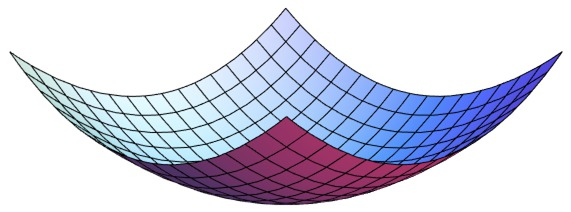

This function has an obvious minimum at $f(0, 0) = 3$.

Let's minimize this function using our conjugate gradient, and output the minimum and the gradient evaluation logs:

In [ ]:
-- Create a stop condition that respects a given error tolerance.
stopCondition f tolerance = StopWhen stop
  where stop (Arg a b) (Arg x y) = do
          Arg dx dy <- grad f (Arg x y)
          return $ abs dx < tolerance  && abs dy < tolerance

-- A demo function with minimum at (0, 0)
function x y = x^2 + y^2 + 3

-- Note that we don't need to set an alpha!
let tolerance = 1e-2
let initValue = Arg 3 2
let writer = conjugateGradient function (stopCondition function tolerance) initValue
    (minLoc, messages) = runWriter writer :: (Params (Double -> Double -> Double), [String])

printf "Min at x = %.5f, y = %.5f\n" (x minLoc) (y minLoc)
mapM_ putStrLn (take 10 messages)
printf "... and so on ... (%d evaluations)\n" $ length messages

That concludes the **Conjugate Gradient** notebook. We've derived the nonlinear conjugate gradient algorithm as well as a few simple line searches for it, and then implemented it in our previously-discussed Gradient Descent typeclass heirarchy.